In [36]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [37]:
try:
    combined = pd.read_pickle('combined.pkl')
except:
    prices, combined = build_prices_dfs()
    pd.to_pickle(combined, 'combined.pkl')

In [38]:
FEATURE_COLS = ['beta_abs', 'momentum']

In [39]:
X = combined[FEATURE_COLS]
y = np.where(combined['ra_month_return'] > 0, 1, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [43]:
def construct_nn(ann_input, ann_output, n_hidden=64):
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network


In [47]:
ann_input = theano.shared(X_train.values)
ann_output = theano.shared(y_train)
neural_network = construct_nn(ann_input, ann_output)

In [48]:
with neural_network:
    # Run ADVI to estimate posterior means, standard deviations, and the evidence lower bound (ELBO)
    # here is a good chance to demonstrate `cost_part_grad_scale` parameter usage
    # the reason is described here: approximateinference.org/accepted/RoederEtAl2016.pdf
    # to be short it is used to reduce variance of gradient on final iterations
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    pm.fit(n=20000, method=inference)
    # It is time to set `s` to zero
    s.set_value(pm.floatX(0))
    approx = pm.fit(n=30000)

Average Loss = 1.9599e+05: 100%|██████████| 20000/20000 [4:09:47<00:00,  2.49it/s]
Finished [100%]: Average Loss = 1.958e+05
Average Loss = 1.4559e+05: 100%|██████████| 30000/30000 [3:14:31<00:00,  2.60it/s]
Finished [100%]: Average Loss = 1.4512e+05


In [49]:
trace = approx.sample(draws=5000)

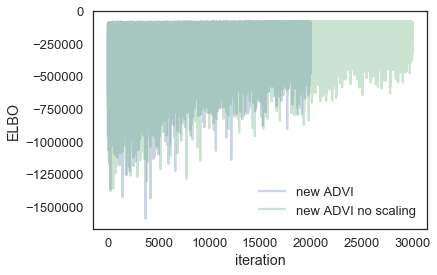

In [51]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(-approx.hist, label='new ADVI no scaling', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [53]:
# create symbolic input
x = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={ann_input: x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

# Create bechmark functions
def production_step1():
    ann_input.set_value(X_test)
    ann_output.set_value(Y_test)
    with neural_network:
        ppc = pm.sample_ppc(trace, samples=500, progressbar=False)

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc['out'].mean(axis=0) > 0.5

def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5

In [54]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

In [55]:
pred

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [57]:
print('Accuracy = {}%'.format((y_test == pred).mean() * 100))

Accuracy = 54.86430691153069%


In [58]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [59]:
ppc = sample_proba(grid_2d ,500)

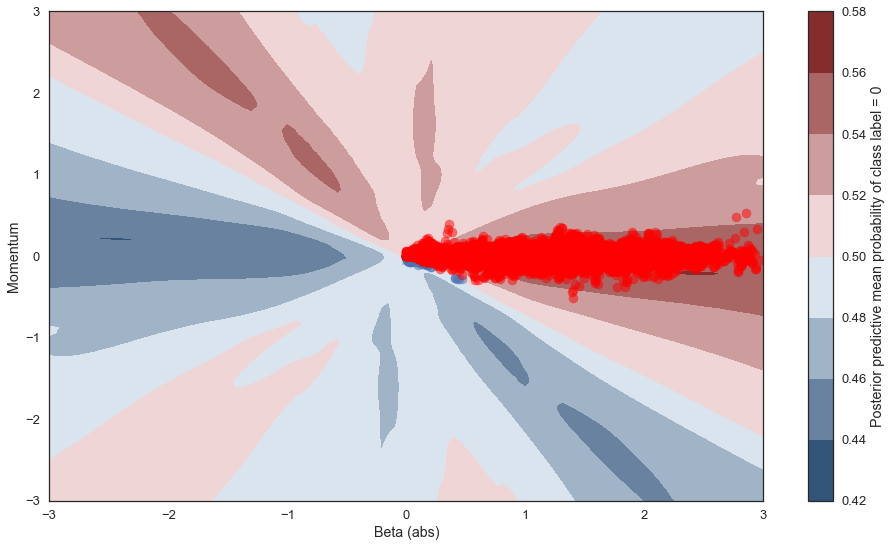

In [67]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test.values[pred==0, 0], X_test.values[pred==0, 1], alpha=.5)
ax.scatter(X_test.values[pred==1, 0], X_test.values[pred==1, 1], color='r', alpha=.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='Beta (abs)', ylabel='Momentum');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

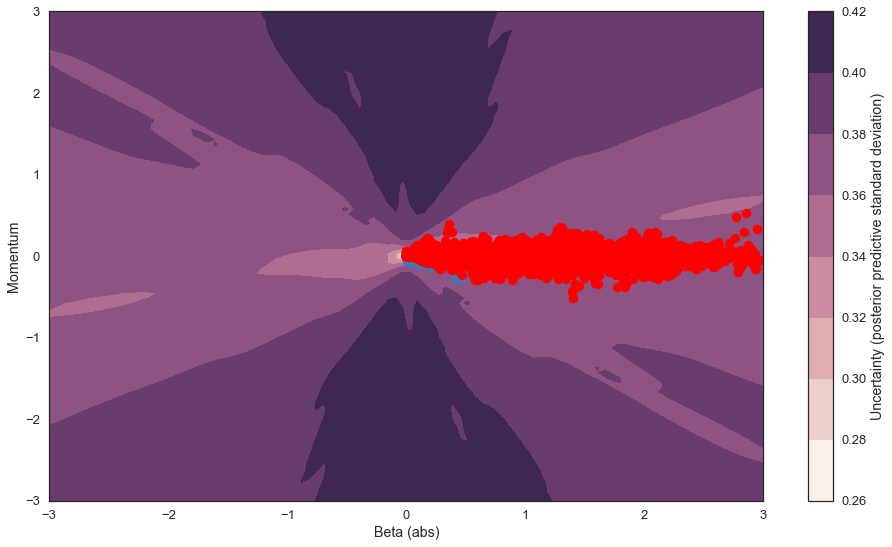

In [69]:

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test.values[pred==0, 0], X_test.values[pred==0, 1])
ax.scatter(X_test.values[pred==1, 0], X_test.values[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='Beta (abs)', ylabel='Momentum');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [71]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

Average Loss = 1.2585e+05: 100%|██████████| 40000/40000 [01:50<00:00, 362.85it/s]
Finished [100%]: Average Loss = 1.2593e+05


In [72]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

In [73]:
print('Accuracy = {}%'.format((y_test == pred).mean() * 100))

Accuracy = 54.84280246010924%


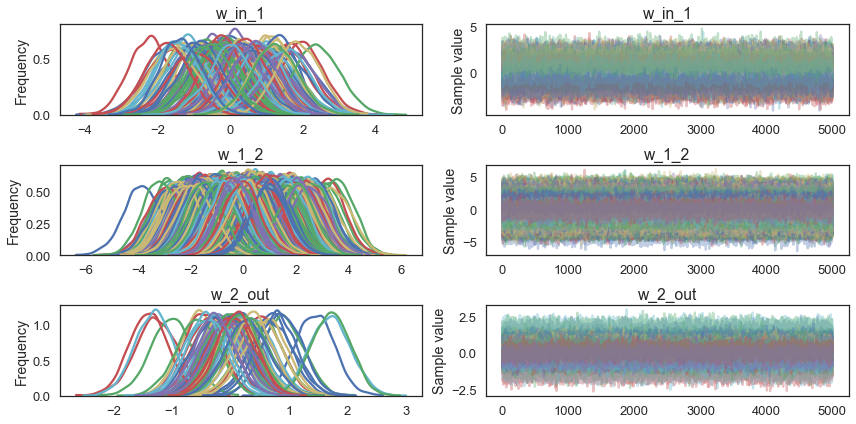

In [74]:
pm.traceplot(trace);